# Necessary imports

In [1]:
import torch
import torch.optim as optim
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader, decollate_batch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, CropForegroundd,
    Resized, DivisiblePadd, ToTensord, RandFlipd, RandAffined, RandScaleIntensityd,
    RandShiftIntensityd, ScaleIntensityRangePercentilesd, EnsureType, AsDiscrete
)
from monai.utils import set_determinism, first
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
from glob import glob
# import time
import matplotlib.pyplot as plt
import numpy as np

from monai.networks.nets import SwinUNETR
from monai.networks.nets.swin_unetr import filter_swinunetr
from monai.networks.utils import copy_model_state

/home/ulrikts/.local/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-04-29 19:29:31.924322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 19:29:31.945914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available 

In [2]:
# Get file paths for train images and labels
data_dir = '/datasets/tdt4265/mic/open/HNTS-MRG'
train_images = sorted([f for f in glob(os.path.join(data_dir, 'train', '*', 'preRT', '*.nii.gz')) if '_mask' not in f])
train_labels = sorted([f for f in glob(os.path.join(data_dir, 'train', '*', 'preRT', '*.nii.gz')) if '_T2' not in f])

val_images = sorted([f for f in glob(os.path.join(data_dir, 'test', '*', 'preRT', '*.nii.gz')) if '_mask' not in f])
val_labels = sorted([f for f in glob(os.path.join(data_dir, 'test', '*', 'preRT', '*.nii.gz')) if '_T2' not in f])

train_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)] 
val_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)] 

Transform data

In [3]:


# 1) Load the images
# 2) Do necessary transforms (d means for dictionary)
# 3) Convert into Monai metatensor

original_train_transforms = Compose( # Just to see difference
    [
        LoadImaged(keys=['image', 'label']),
        # Transforms
        EnsureChannelFirstd(keys=['image', 'label']),
        ToTensord(keys=['image', 'label'])
    ]
)


train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5,1.5,2)),
    # CropForegroundd(keys=['image', 'label'], source_key='image'),
    ScaleIntensityRangePercentilesd(keys='image', lower=0.5, upper=99.5,
                               b_min=0.0, b_max=1.0, clip=True),

    # --- AUGMENTATION BLOCK ---
    RandFlipd(keys=['image','label'], spatial_axis=0, prob=0.10),
    RandFlipd(keys=['image','label'], spatial_axis=1, prob=0.10),
    RandAffined(
        keys=['image','label'],
        rotate_range=(0.1,0.1,0.05),    # small rotations (~±6° in-plane)
        scale_range=(0.1,0.1,0.05),     # small scaling ±10%
        mode=('bilinear','nearest'),
        prob=0.15
    ),
    RandScaleIntensityd(keys='image', factors=0.1, prob=0.10),
    RandShiftIntensityd(keys='image', offsets=0.1, prob=0.10),
    # -------------------------------

    Resized(keys=['image','label'], spatial_size=[256,256,96]),
    DivisiblePadd(keys=['image','label'], k=16, mode='constant', constant_values=0),
    ToTensord(keys=['image','label'])
])

val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        # Transforms
        EnsureChannelFirstd(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)), # Ensure all voxels are same size
        # CropForegroundd(keys=['image', 'label'], source_key='image'),
        ScaleIntensityRangePercentilesd(keys='image', lower=0.5, upper=99.5,
                               b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=['image', 'label'], spatial_size=[256, 256, 96]),
        DivisiblePadd(keys=['image', 'label'], k=16, mode='constant', constant_values=0), # pad both image and label
        ToTensord(keys=['image', 'label'])
    ]
)

Create Dataset and DataLoader

In [4]:
original_dataset = Dataset(data=train_files, transform=original_train_transforms)
original_loader = DataLoader(dataset=original_dataset, batch_size=6) # all slices, but only one patient

train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=6) # all slices, but only one patient

val_dataset = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=6) # all slices, but only one patient

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Define the 3D UNet model
model = UNet(
    spatial_dims=3,  # 3D model
    in_channels=1,   # Number of input channels (grayscale images)
    out_channels=3,  # Number of output classes (foreground & background)
    channels=(16, 32, 64, 128, 256),  # Feature map sizes per layer
    strides=(2, 2, 2, 2),  # Downsampling factors
    num_res_units=2,  # Number of residual units per layer
    dropout=0.1 # fight overfitting
).to(device)  # Move model to GPU if available


# model = SwinUNETR(
#     img_size=(160, 160, 96),
#     in_channels=1,
#     out_channels=3,
#     feature_size=48,
#     # depths = (2,2,2,2)
#     # num_heads=(3,6,12,24)
#     dropout_path_rate=0.2
# ).to(device)

# ckpt = torch.load("model_swinvit.pt", map_location=device, weights_only=True)

# model.load_from(ckpt)
# print("Using pretrained Swin UneTR backbone weights!")


Using device: cuda


In [6]:
max_epochs = 200
val_interval = 5
best_metric = -1
best_metric_epoch = -1
best_epoch = -1
epoch_loss_values = []
metric_values = []
lr_values = []

post_pred = Compose([
    EnsureType(),
    AsDiscrete(argmax=True, to_onehot=3)
])

post_label = Compose([
    EnsureType(),
    AsDiscrete(to_onehot=3)
])

dice_metric = DiceMetric(include_background=True, reduction="mean_batch", get_not_nans=True)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # add weight decay regularization due to overfitting

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',        # 'max' because we want to maximize the Dice score
    factor=0.5,        # multiply LR by this factor when reducing
    patience=2,        # wait for this many validations before reducing LR
    min_lr=1e-6        # don't reduce LR below this value
)

In [7]:
from monai.inferers import sliding_window_inference

SEED = 42
set_determinism(seed=SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

CHECKPOINT_DIR = "./checkpoints"
BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/best_metric_model.pth"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def run_validation(model, val_loader, post_pred, post_label, dice_metric, device, epoch):
    model.eval()
    
    with torch.no_grad():
        for val_data in val_loader:
            images = val_data["image"].to(device)
            labels = val_data["label"].to(device)

            outputs = sliding_window_inference(
                images, roi_size=(256,256,96), sw_batch_size=2, predictor=model
            )

            # post‐process into lists of tensors
            y_pred = [post_pred(x) for x in decollate_batch(outputs)]
            y_true = [post_label(x) for x in decollate_batch(labels)]

            dice_metric(y_pred=y_pred, y=y_true)
                           
    metric, _ = dice_metric.aggregate()
    dice_metric.reset()
    
    dice_bg    = metric[0].item()
    dice_cls1  = metric[1].item()
    dice_cls2  = metric[2].item()

    # average over all three
    avg_dice_all = metric.mean().item()
    avg_dice_foregrounds = metric[1:].mean().item()

    metric_values.append((
    epoch + 1,
    dice_bg,
    dice_cls1,
    dice_cls2,
    avg_dice_foregrounds
    ))

    print(f"Dice(background): {dice_bg:.4f}, Dice(class1): {dice_cls1:.4f}, "
          f"Dice(class2): {dice_cls2:.4f}, Avg(foregrounds): {avg_dice_foregrounds:.4f}, "
          f"Avg Dice (including background): {avg_dice_all:.4f}")

    # return foreground dice
    return avg_dice_foregrounds


# --- training loop with early stopping ---
patience = 5        # how many epochs to wait for improvement
counter = 0         # no-improve counter

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch+1}/{max_epochs}")
    model.train()
    running_loss = 0.0

    for step, batch_data in enumerate(train_loader, 1):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"  step {step:>3}/{len(train_loader):<3}  loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    print(f"  Average Train Loss: {avg_train_loss:.4f}")
    epoch_loss_values.append((epoch+1, avg_train_loss))
    lr_values.append((epoch+1, optimizer.param_groups[0]['lr']))

    # run validation every val_interval epochs
    if (epoch + 1) % val_interval == 0:
        val_metric = run_validation(model, val_loader, post_pred, post_label, dice_metric, device, epoch)
        print(f"  Validation Dice: {val_metric:.4f}   (best: {best_metric:.4f} at epoch {best_epoch})")
    
        # Update the scheduler based on validation metric
        scheduler.step(val_metric)

        # early-stopping logic
        if val_metric > best_metric:
            best_metric = val_metric
            best_epoch = epoch + 1
            counter = 0

            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_metric": best_metric,
                },
                BEST_MODEL_PATH,
            )
            print(f"  --> New best model saved at epoch {best_epoch}!")

        else:
            counter += 1
            if counter >= patience:
                print(f"  Early stopping: no improvement in {patience} validations.")
                break


Epoch 1/200
  step   1/22   loss: 0.8254
  step   2/22   loss: 0.8244
  step   3/22   loss: 0.8216
  step   4/22   loss: 0.8221
  step   5/22   loss: 0.8202
  step   6/22   loss: 0.8201
  step   7/22   loss: 0.8182
  step   8/22   loss: 0.8192
  step   9/22   loss: 0.8168
  step  10/22   loss: 0.8163
  step  11/22   loss: 0.8154
  step  12/22   loss: 0.8138
  step  13/22   loss: 0.8147
  step  14/22   loss: 0.8121
  step  15/22   loss: 0.8137
  step  16/22   loss: 0.8111
  step  17/22   loss: 0.8107
  step  18/22   loss: 0.8098
  step  19/22   loss: 0.8085
  step  20/22   loss: 0.8089
  step  21/22   loss: 0.8081
  step  22/22   loss: 0.8052
  Average Train Loss: 0.8153

Epoch 2/200
  step   1/22   loss: 0.8067
  step   2/22   loss: 0.8061
  step   3/22   loss: 0.8045
  step   4/22   loss: 0.8050
  step   5/22   loss: 0.8031
  step   6/22   loss: 0.8035
  step   7/22   loss: 0.8019
  step   8/22   loss: 0.8032
  step   9/22   loss: 0.8011
  step  10/22   loss: 0.8006
  step  11/22   l

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-s" (-> linestyle='-'). The keyword argument will take precedence.


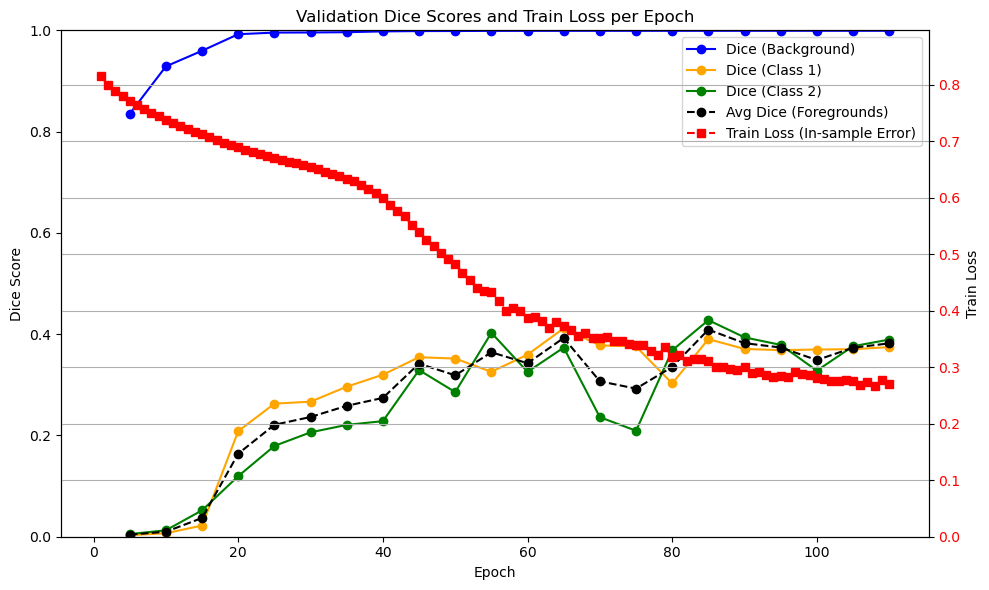

In [9]:
import matplotlib.pyplot as plt

# Unpack the data from your metric collections.
# For the dice metrics (validation), each element in metric_values is:
# (epoch, dice_bg, dice_cls1, dice_cls2, avg_dice_foregrounds)
epochs_dice, dice_bg, dice_cls1, dice_cls2, avg_dice_fg = zip(*metric_values)

# For the training loss (average in-sample error), each element in epoch_loss_values is:
# (epoch, avg_train_loss)
epochs_loss, train_loss = zip(*epoch_loss_values)

# Create a figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Dice scores on the primary y-axis.
ax1.plot(epochs_dice, dice_bg, 'b-o', label='Dice (Background)')
ax1.plot(epochs_dice, dice_cls1, color='orange', marker='o', linestyle='-', label='Dice (Class 1)')
ax1.plot(epochs_dice, dice_cls2, 'g-o', label='Dice (Class 2)')
ax1.plot(epochs_dice, avg_dice_fg, 'k--o', label='Avg Dice (Foregrounds)')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Dice Score")
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y')

# Create a second y-axis for the training loss.
ax2 = ax1.twinx()
ax2.plot(epochs_loss, train_loss, 'r-s', linestyle='--', label='Train Loss (In-sample Error)')
ax2.set_ylabel("Train Loss")
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(train_loss) * 1.1)  # adjust as needed

# Combine legends from both axes.
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.title("Validation Dice Scores and Train Loss per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()